In [4]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [5]:
# =========================================================
# 0. CARREGAMENTO DA BASE DA BÍBLIA
# =========================================================

# Caminho do arquivo (ajuste se necessário)
caminho_dados = r"C:\Users\lucas\OneDrive\Área de Trabalho\biblia_network\blivre.xlsx"

# Esperado no CSV:
# Book | Chapter | Verse | Text
df = pd.read_excel(caminho_dados)

# Garantia básica de tipos
df['Verse ID'] = df['Verse ID'].astype(int)
df['Book Name'] = df['Book Name'].astype(str)
df['Book Number'] = df['Book Number'].astype(int)
df['Chapter'] = df['Chapter'].astype(int)
df['Verse'] = df['Verse'].astype(int)
df['Text'] = df['Text'].astype(str)


In [6]:
# =========================================================
# 1. NLP – TOKENIZAÇÃO E LEMATIZAÇÃO (PORTUGUÊS)
# =========================================================
nlp = spacy.load("pt_core_news_sm")

def preprocess_text(text):
    if pd.isnull(text):
        return []
    
    doc = nlp(text)
    return [
        token.lemma_.lower()
        for token in doc
        if token.is_alpha and not token.is_stop and not token.is_punct
    ]

df['tokens'] = df['Text'].apply(preprocess_text)

# =========================================================
# 2. EXTRAÇÃO DE ENTIDADES (NER)
# =========================================================
def extract_entities(text):
    if pd.isnull(text):
        return []
    doc = nlp(text)
    return [ent.text.strip() for ent in doc.ents]

df['entities'] = df['Text'].apply(extract_entities)

In [11]:
# =========================================================
# 3. DICIONÁRIO DE ENTIDADES ÚNICAS (COM FILTRO POR LIVRO)
# =========================================================
def get_unique_entities(df, book=None):
    if book:
        df = df[df['Book Name'].str.lower() == book.lower()]

    entities = {
        str(ent).strip()
        for ents in df['entities']
        if isinstance(ents, list)
        for ent in ents
        if pd.notnull(ent)
    }

    return sorted(entities, key=str.lower)

In [12]:
# =========================================================
# 4. REDE ENTIDADE → PALAVRAS (COOCORRÊNCIA)
# =========================================================
def entity_token_network(
    df,
    entity_name,
    book,
    min_freq=3
):
    entity_lower = entity_name.lower()

    df_filtered = df[
        (df['Book Name'].str.lower() == book.lower()) &
        (df['entities'].apply(
            lambda ents: isinstance(ents, list) and
            any(entity_lower == str(e).lower() for e in ents)
        ))
    ]

    if df_filtered.empty:
        print(f"Nenhum versículo encontrado para '{entity_name}' em {book}")
        return None

    token_counter = Counter()
    for tokens in df_filtered['tokens']:
        if isinstance(tokens, list):
            token_counter.update(tokens)

    token_counter = {
        tok: freq for tok, freq in token_counter.items()
        if freq >= min_freq and tok.lower() != entity_lower
    }

    if not token_counter:
        print(f"Nenhuma palavra atingiu min_freq={min_freq}")
        return None

    G = nx.Graph()
    G.add_node(entity_name, type='entity')

    for token, freq in token_counter.items():
        G.add_node(token, type='token')
        G.add_edge(entity_name, token, weight=freq)

    return G

In [13]:
# =========================================================
# 5. VISUALIZAÇÃO DA REDE
# =========================================================
def plot_entity_network(G, title="Rede Entidade–Palavras", k=0.9):
    if G is None or G.number_of_edges() == 0:
        print("Rede vazia — nada para plotar.")
        return

    pos = nx.spring_layout(G, k=k, seed=42)

    node_colors = [
        'red' if G.nodes[n]['type'] == 'entity' else 'skyblue'
        for n in G.nodes
    ]

    node_sizes = [
        1300 if G.nodes[n]['type'] == 'entity' else 450
        for n in G.nodes
    ]

    edge_weights = [G[u][v]['weight'] for u, v in G.edges]

    plt.figure(figsize=(14, 10))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        node_size=node_sizes,
        font_size=9,
        edge_color='gray',
        width=[w * 0.25 for w in edge_weights],
        alpha=0.85
    )

    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()



In [14]:
# 6.1 Dicionário de entidades do livro
entidades_genesis = get_unique_entities(df, book='Gênesis')

In [23]:
# 6.2 Rede da entidade "Deus"
G_deus = entity_token_network(
    df,
    entity_name='adão',
    book='Gênesis',
    min_freq=4
)

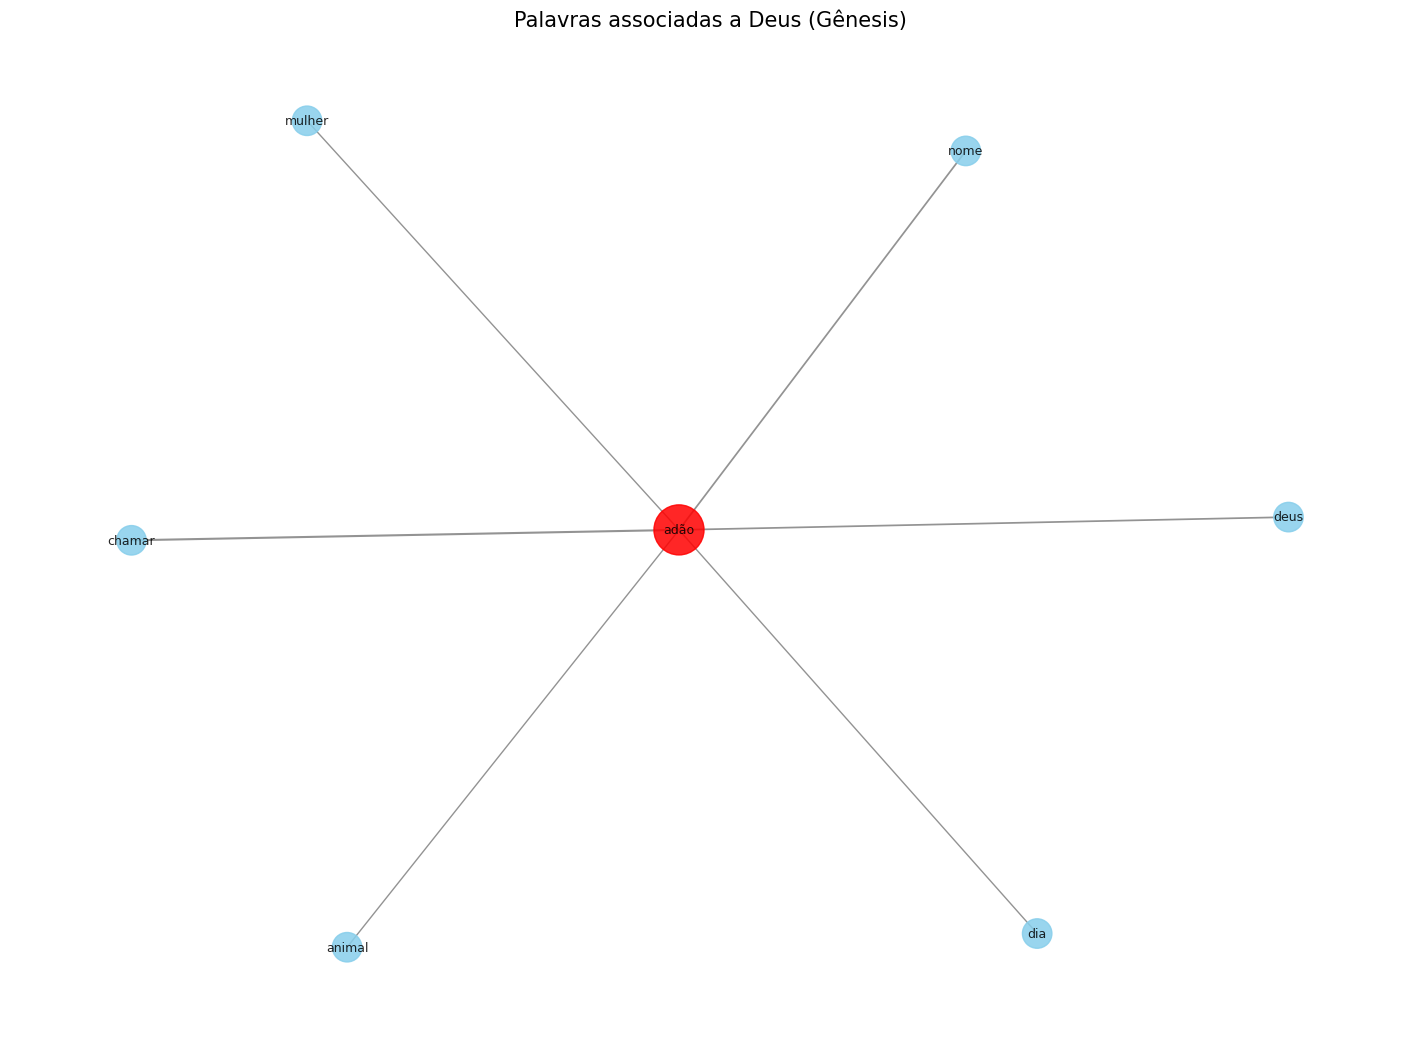

In [24]:
plot_entity_network(
    G_deus,
    title='Palavras associadas a Deus (Gênesis)',
    k=0.7
)

In [26]:
from networkx.algorithms.community import louvain_communities

communities = louvain_communities(G_deus, seed=42)


In [27]:
communities

[{'adão', 'animal', 'chamar', 'deus', 'dia', 'mulher', 'nome'}]

In [28]:
def ego_entity_network(G, entity, radius=2):
    return nx.ego_graph(G, entity, radius=radius)

In [29]:
def build_entity_entity_network(df):
    G = nx.Graph()
    for ents in df['entities']:
        if len(ents) > 1:
            for e1 in ents:
                for e2 in ents:
                    if e1 != e2:
                        G.add_edge(e1, e2, weight=1)
    return G